# ___

# [ Demo THR vs. ML for image classification]

**Department of Applied Geoinformatics and Carthography, Charles University** 

*Lukas Brodsky lukas.brodsky@natur.cuni.cz*


___

### Task Statement

This notebook demonstrates the use of both a simple **Thresholding** approach and a **Machine Learning–based classification model** to segment supraglacial lakes from Sentinel-2 satellite imagery acquired over Greenland.

### Problem Type

Supervised classification (binary image segmentation)

In [38]:
# packages imports 
import os
import numpy as np
import rasterio 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline 

In [39]:
os.getcwd()

'/Users/lukas/Work/prfuk/ownCloud/Vyuka/Machine_learning_geosciences/src/machine_learning_geosciences/01_Computing_environment'

In [40]:
# data 
path = '../data/lab1'
img_fn = os.path.join(path, 'S2_20220827T152809_T22WEC_20m_subset.tif')
labels_fn = os.path.join(path, 'sgl_s2_20220827_labels.tif')
labels2_fn = os.path.join(path, 'sgl_s2_20220827_labels2.tif')

In [41]:
os.listdir(path)

['sgl_s2_20220827_labels.tif',
 'sgl_s2_20220827_labels2.tif',
 'S2_20220827T152809_T22WEC_20m_subset.tif']

### Open the Sentinel-2 image and labels in QGIS/ArcGis and explore the data! 

### Open the same data in Python and explore! 

In [42]:
# open datasets
with rasterio.open(img_fn) as img_ds:
    # rasterio reads as (bands, rows, cols)
    image = img_ds.read()                      # shape: (B, H, W)
    image = np.transpose(image, (1, 2, 0))     # -> (H, W, B)

with rasterio.open(labels_fn) as labels_ds:
    labels = labels_ds.read(1).astype(np.uint8)

with rasterio.open(labels2_fn) as labels2_ds:
    labels2 = labels2_ds.read(1).astype(np.uint8)


In [43]:
# input image
image.shape

(1534, 2476, 10)

In [66]:
print(type(image))

<class 'numpy.ndarray'>


In [44]:
# reference labels (training data)
labels.shape

(1534, 2476)

In [45]:
# 1 ... supraglacial lake, 2 ... ice 
np.unique(labels2)

array([0, 1, 2], dtype=uint8)

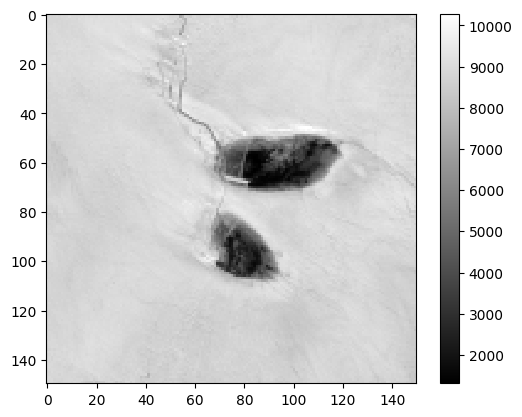

In [46]:
# cmap='Spectral'
plt.imshow(image[50:200, 100:250, 0], cmap='gray', interpolation='nearest')
plt.colorbar()

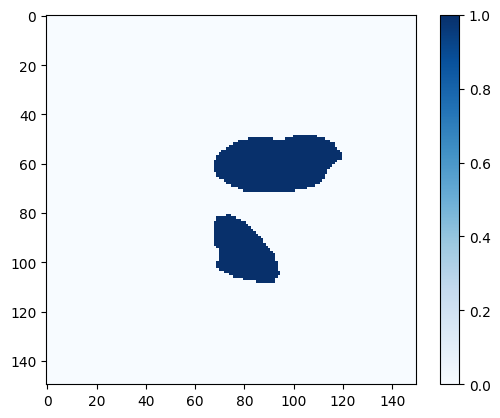

In [47]:
plt.imshow(labels[50:200, 100:250], cmap='Blues', interpolation='nearest')
plt.colorbar()

### Model 1: THR 

In [48]:
# define model 1 

def model1(img, bnd, thr): 
    cls = (img[:, :, bnd] < thr) * 1
    return cls

### Select your own threshold value and apply! 

In [67]:
# select band and boundary value from image 
treshold = 3000 # 7217 # 6634 # 7517 # 4426
# classify based on model 
SGL1 = model1(image, 0, treshold)

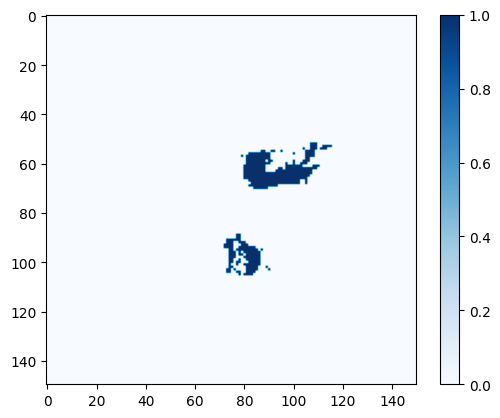

In [50]:
# Plot the result on small sample 
plt.imshow(SGL1[50:200, 100:250], cmap='Blues')
plt.colorbar()

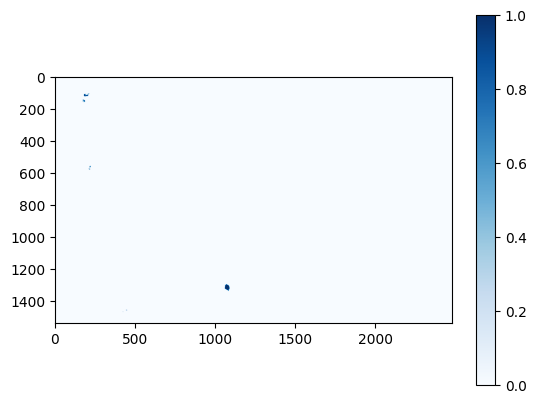

In [51]:
# Plot full extend 
plt.imshow(SGL1, cmap='Blues')
plt.colorbar()

### Accuracy assesment (based on reference labels)

In [52]:
acc = accuracy_score(labels, SGL1)
print('Model1 accuracy is: {:.2f}%'.format(acc * 100))

Model1 accuracy is: 45.63%


## Model 2: Random Forest (Machine Learning) 

In [53]:
np.unique(labels2[labels2>0])

array([1, 2], dtype=uint8)

In [54]:
labels_map = np.unique(labels2[labels2 > 0])
print('The training data include {n} classes: {classes}'.format(n=labels_map.size, 
                                                                classes=labels_map))

The training data include 2 classes: [1 2]


In [55]:
n_samples = (labels2 > 0).sum()
print("Numnber of samples: {}".format(n_samples))

Numnber of samples: 43762


In [56]:
X = image[labels2 > 0, :]
y = labels2[labels2 > 0]

In [57]:
clf = RandomForestClassifier(max_depth=20, oob_score=True, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=20, oob_score=True, random_state=0)

In [58]:
print('Our OOB prediction of accuracy is: {oob:.2f}%'.format(oob=clf.oob_score_ * 100))

Our OOB prediction of accuracy is: 99.84%


In [59]:
cls = clf.predict(X)

In [60]:
new_shape = (image.shape[0] * image.shape[1], image.shape[2])

img_as_array = image[:, :, :].reshape(new_shape)
# print('Reshaped from {o} to {n}'.format(o=image.shape,
#                                         n=img_as_array.shape))

# Now predict for each pixel
class_prediction = clf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(image[:, :, 0].shape)

In [61]:
# define model 2
roi = np.ones((image.shape[1], image.shape[2])) 

def model2(img, lbl): 
    clf = RandomForestClassifier(max_depth=20, oob_score=True, random_state=0)
    X = img[lbl > 0, :]
    y = lbl[lbl > 0]
    clf.fit(X, y)
    print('Model2 accuracy is: {oob:.2f}%'.format(oob=clf.oob_score_ * 100))
    new_shape = (img.shape[0] * img.shape[1], img.shape[2])
    img_as_array = img[:, :, :].reshape(new_shape)
    cls = clf.predict(img_as_array)
    cls_pred = cls.reshape(img[:, :, 0].shape)
        
    return cls 


In [62]:
SGL2 = model2(image, labels2)

Model2 accuracy is: 99.84%


### What makes the difference?

In [63]:
# --- Feature space & decision boundary visualization ---
# prepare dataset (use labelled pixels)
mask = labels2 > 0
X = image[mask][:, :2]   # use first two bands for visualization
y = labels2[mask]

# train RF again for visualization
rf = RandomForestClassifier(max_depth=20, random_state=0)
rf.fit(X, y)

# simple threshold model (on band 0)
threshold = X[:,0].mean()

In [64]:
# create meshgrid
x_min, x_max = X[:,0].min(), X[:,0].max()
y_min, y_max = X[:,1].min(), X[:,1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]

# RF decision
rf_pred = rf.predict(grid).reshape(xx.shape)

# threshold decision
thr_pred = (xx > threshold).astype(int)

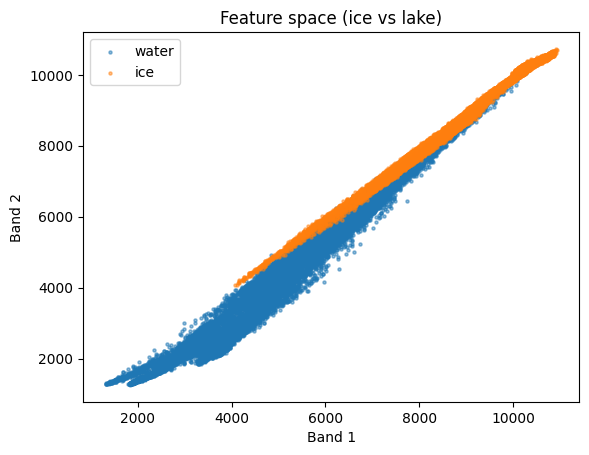

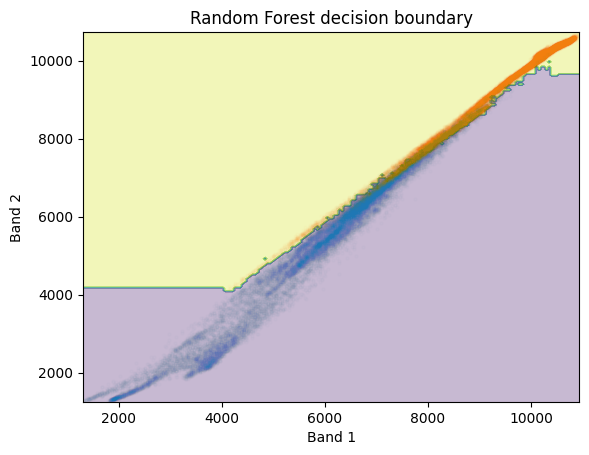

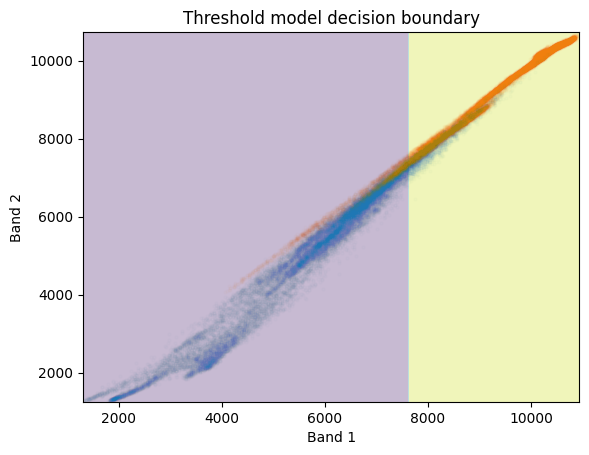

In [65]:
# plot feature space
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], s=5, alpha=0.5, label='water')
plt.scatter(X[y==2,0], X[y==2,1], s=5, alpha=0.5, label='ice')
plt.title("Feature space (ice vs lake)")
plt.xlabel("Band 1")
plt.ylabel("Band 2")
plt.legend()
plt.show()

# RF boundary
plt.figure()
plt.contourf(xx, yy, rf_pred, alpha=0.3)
plt.scatter(X[y==1,0], X[y==1,1], s=5, alpha=0.01)
plt.scatter(X[y==2,0], X[y==2,1], s=5, alpha=0.01)
plt.title("Random Forest decision boundary")
plt.xlabel("Band 1")
plt.ylabel("Band 2")
plt.show()

# Threshold boundary
plt.figure()
plt.contourf(xx, yy, thr_pred, alpha=0.3)
plt.scatter(X[y==1,0], X[y==1,1], s=5, alpha=0.01)
plt.scatter(X[y==2,0], X[y==2,1], s=5, alpha=0.01)
plt.title("Threshold model decision boundary")
plt.xlabel("Band 1")
plt.ylabel("Band 2")
plt.show()
